In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import time
from datetime import datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
SAVE_SCORE = True
SAVE_MODEL = True
SAVE_PLOT = True
# -------------------------------------------------------------------

In [2]:
# jupyter notebook settings

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_green = "#006400"
dark_cyan = "#008B8B"
dark_slate = "#2F4F4F"
dark_magenta = "#8B008B"
dark_red = "#8B0000"
dark_olive = "#556B2F"
crimson = "#DC143C"

yellow_green = "#9ACD32"
lime_green = "#32CD32"
lime = "#00FF00"
gold = "#FFD700"
golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"
light_red = "#F1948A"
highlight_green = "green"
highlight_red = "red"

color_train = dark_cyan
color_test = "#1f77b4"
color_future = "#ff7f0e"
color_forecast = "#ff7f0e"
color_predict = yellow_green


In [3]:
# funções auxiliares

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(
                    train, 
                    order=param, 
                    seasonal_order=param_seasonal, 
                    enforce_stationarity=False, 
                    enforce_invertibility=False
                )
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print(f"SARIMA{param}x{param_seasonal}12 - AIC:{aic}")
            
            except Exception as e:
                print(f"Erro com parâmetros {param}x{param_seasonal}12: {e}")
                continue
    
    print(f"Melhor modelo: SARIMA{best_order}x{best_seasonal_order}12 - AIC:{best_aic}")
    return best_order, best_seasonal_order
    

def sarima_optimizer_mae(train, test, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=len(test))
                y_pred = y_pred_test.predicted_mean
                
                mae = mean_absolute_error(test, y_pred)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print(f"SARIMA{param}x{param_seasonal}12 - MAE:{mae}")
            
            except Exception as e:
                print(f"Erro com parâmetros {param}x{param_seasonal}12: {e}")
    print(f"Melhor modelo: SARIMA{best_order}x{best_seasonal_order}12 - MAE:{best_mae}")
    return best_order, best_seasonal_order


# ---------------------------------------------------------------------------------------------------------------------
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()

    if y_true.shape != y_pred.shape:
        raise ValueError(f"y_true e y_pred devem ter o mesmo tamanho: {y_true.shape} != {y_pred.shape}")

    mask = y_true != 0
    # return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


# sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


# MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    mae_model = mean_absolute_error(y_true, y_pred)

    try:
        hour_median_train = y_train.groupby(y_train.index.hour).median()
        mapped_values = y_true.index.hour.map(hour_median_train)
        mae_naive = mean_absolute_error(y_true, mapped_values)

        return 0 if mae_naive == 0 else mae_model / mae_naive

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    return meam_error_model / mean_error_naive


def calculate_forecast_accuracy(y_true, y_pred, y_train):
    y_true_day = y_true.between_time('06:00:00', '18:00:00')
    y_pred_day = y_pred.between_time('06:00:00', '18:00:00')
    y_train_day = y_train.between_time('06:00:00', '18:00:00')

    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "mse": mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mase": mean_absolute_scaled_error(y_true, y_pred, y_train),
        "mae_day": mean_absolute_error(y_true_day, y_pred_day),
        "rmse_day": mean_squared_error(y_true_day, y_pred_day, squared=False),
        "mse_day": mean_squared_error(y_true_day, y_pred_day),
        "r2_day": r2_score(y_true_day, y_pred_day),
        "mape_day": mean_absolute_percentage_error(y_true_day, y_pred_day),
        "mase_day": mean_absolute_scaled_error(y_true_day, y_pred_day, y_train_day),
    }


def print_forecast_accuracy(y_true, y_pred, y_train, title):
    acc = calculate_forecast_accuracy(y_true, y_pred, y_train)

    print(f"Resumo das métricas de precisão (forecast accuracy - {title})".center(120))
    print("-" * 120)
    # Alinhas cabelhaço em cima das metricas  (dn , dia)
    print(f"{'Métrica |':<10} {'24h':<6}| {'(dia)':<7}| {'Descrição':<50}")
    print("-" * 120)
    print(f"MAE     | ({acc['mae']:>5.2f} - {acc['mae_day']:>5.2f}) | As previsões, em média, estão ({acc['mae']:0.2f} - {acc['mae_day']:0.2f}) unidades distantes dos valores reais.")
    print(f"RMSE    | ({acc['rmse']:>5.2f} - {acc['rmse_day']:>5.2f}) | O erro médio do seu modelo é de ({acc['rmse']:0.2f} - {acc['rmse_day']:0.2f}) unidades em relação aos valores observados.")
    print(f"R²      | ({acc['r2']:>5.2f} - {acc['r2_day']:>5.2f}) | O coeficiente de determinação R² é ({acc['r2']*100:0.2f}% - {acc['r2']*100:0.2f}%).")
    print(f"MSE     | ({acc['mse']:>5.2f} - {acc['mse_day']:>5.2f}) | A média dos quadrados das diferenças entre os valores previstos e reais é ({acc['mse']:0.2f} - {acc['mse']:0.2f})")
    print(f"MAPE    | ({acc['mape']:>5.2f} - {acc['mape_day']:>5.2f}) | As previsões, em média, estão desviando em ({acc['mape']*100:0.2f}% - {acc['mape']*100:0.2f}%) dos valores reais.")
    print(f"MASE    | ({acc['mase']:>5.2f} - {acc['mase_day']:>5.2f}) | O erro médio do seu modelo é {acc['mase']:0.2f} vezes maior que o erro médio do modelo Naive Lag.")
    print("-" * 120)

# ----------------------------------------------------------------------------------------------------------------------------


def plot_forecast(df, name, start=None, end=None, span=False):
    if SAVE_PLOT:
        span = False

    df_plot = df[start:end] if start and end else df.copy()
    plt.figure(figsize=(22, 5))

    for col in df.columns:
        params = {
            "train": {"label": "Train set", "color": color_train, "lw": 2, "ls": "-"},
            "test": {"label": "Test set", "color": color_test, "lw": 2, "ls": "-"},
            "y_pred": {"label": "Predict", "color": color_forecast, "lw": 2, "ls": "-"},
        }.get(col, {"label": None, "color": None, "lw": None})

        if 'pred' in col:
            params.update({'lw': 3, 'ls': '--'})

        if all(params.values()):
            plt.plot(
                df_plot.index, 
                df_plot[col], 
                label=params["label"], 
                color=params["color"], 
                lw=params["lw"], 
                ls=params["ls"]
            )
        
        if span:
            df_span = df_plot[df_plot["test"].notnull()]["test"]
            plt.axvspan(df_span.index.min(), df_span.index.max(), color=light_blue, alpha=0.09)
    
    if not SAVE_PLOT:
        plt.title(f"LDTEA - {name} Predict Test set", fontsize=16, fontweight="bold", pad=20)

    plt.ylabel("KWh", fontsize=16, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", alpha=0.5, linewidth=1.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="upper left",
        fontsize=16,
        frameon=True,
        shadow=True,
        framealpha=1,
        facecolor="white",
        bbox_to_anchor=(1, 1), 
    )
    plt.tight_layout()
    if SAVE_PLOT:
        plt.savefig(f"../figures/sarima/{name}.pdf", dpi=300)
        plt.savefig(f"../figures/sarima/{name}.svg", dpi=300)
    plt.show()


def save_model(model, model_type):
    notebook_dir = Path.cwd()
    model_path = notebook_dir.parent / "models"
    
    if not model_path.exists():
        model_path.mkdir()
    
    file_path = model_path / f"{model_type}_model.joblib"
    joblib.dump(model, file_path)
    print(f"Modelo {model_type} salvo em {model_path}")


def save_score_metrics(metrics, name, metadata=None):
    metrics_path = Path.cwd().parent / "data" / "results" / "estatical_models"
    metrics_path.mkdir(parents=True, exist_ok=True)
    file_path = metrics_path / f"{name}.csv"

    df = pd.DataFrame([metrics]) if not isinstance(metrics, pd.DataFrame) else metrics.copy()
    df = df.assign(model=name, features=df.index, dataset=metadata.get("dataset", ""))

    columns_order = ["model", "features", "dataset"] + [col for col in df.columns if col not in ["model", "features", "dataset"]]
    df = df[columns_order]

    if metadata:
        df = df.assign(**metadata)

    try:
        mode = "a" if file_path.exists() else "w"
        header = not file_path.exists()
        df.to_csv(file_path, mode=mode, header=header, index=False)
        print(f"Métricas salvas com sucesso em: {file_path}")
    except Exception as e:
        print(f"Erro ao salvar as métricas: {e}")



In [4]:
# Constants:

FREQUENCY = "H"
DATE_COL = "date_time"
TARGET = "ldtea_avg"

START_DATE = "2023-06-01 00:00:00"
SPLIT_TEST_DATE = "2024-03-19 23:59:59"
SPLIT_DATE_EVAL = "2024-05-31 23:59:59"
END_DATE = "2024-06-30 23:59:59"

# START_DATE = pd.to_datetime("2023-06-01 00:00:00")
# SPLIT_DATE = pd.to_datetime("2023-09-15 23:59:59")
# END_DATE = pd.to_datetime("2023-09-30 23:59:59")


In [5]:
# Carregar dados de produção de energia (freq 1H).

file_path = "../data/final/1.1_energy_prod_ldtea.csv"
cols = [DATE_COL, TARGET]

df_raw = pd.read_csv(file_path, usecols=cols, parse_dates=[DATE_COL],  index_col=DATE_COL)
df_raw.sort_index(inplace=True)
df_raw = df_raw.asfreq(FREQUENCY)

print(f"index - {df_raw.index.min()} {df_raw.index.max()}")
print(f"freq : {df_raw.index.freq} - shape: {df_raw.shape}")
df_raw

index - 2023-06-01 00:00:00-03:00 2024-06-30 23:00:00-03:00
freq : <Hour> - shape: (9504, 1)


ldtea_avg
date_time                           
2023-06-01 00:00:00-03:00       0.00
2023-06-01 01:00:00-03:00       0.00
2023-06-01 02:00:00-03:00       0.00
2023-06-01 03:00:00-03:00       0.00
2023-06-01 04:00:00-03:00       0.00
...                              ...
2024-06-30 19:00:00-03:00       4.08
2024-06-30 20:00:00-03:00       4.08
2024-06-30 21:00:00-03:00       4.08
2024-06-30 22:00:00-03:00       4.08
2024-06-30 23:00:00-03:00       4.08

[9504 rows x 1 columns]

In [6]:
# Dividir os dados em treino, teste e validação

df_base = df_raw.loc[START_DATE:SPLIT_DATE_EVAL].copy()
df_train = df_raw.loc[START_DATE:SPLIT_TEST_DATE].copy()
df_test = df_raw.loc[SPLIT_TEST_DATE:SPLIT_DATE_EVAL].copy()
df_eval = df_raw.loc[SPLIT_DATE_EVAL:END_DATE].copy()

datasets = [
    ('df_raw', df_raw),
    ('df_base', df_base),
    ('df_train', df_train),
    ('df_test', df_test),
    ('df_eval', df_eval)
]

for name, df in datasets:
    shape = f"({df.shape[0]}, {df.shape[1]})"
    date_range = f"{df.index.min()} - {df.index.max()}"
    print(f"{name:<12} {shape:<14} {date_range:<23}")

total_rows = df_raw.shape[0]
train_rows = df_train.shape[0]
test_rows = df_test.shape[0]
eval_rows = df_eval.shape[0]

print(f"\nProportion of train data: {train_rows / total_rows:.2%}")
print(f"Proportion of test data: {test_rows / total_rows:.2%}")
print(f"Proportion of evaluation data: {eval_rows / total_rows:.2%}")

df_raw       (9504, 1)      2023-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00
df_base      (8784, 1)      2023-06-01 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_train     (7032, 1)      2023-06-01 00:00:00-03:00 - 2024-03-19 23:00:00-03:00
df_test      (1752, 1)      2024-03-20 00:00:00-03:00 - 2024-05-31 23:00:00-03:00
df_eval      (720, 1)       2024-06-01 00:00:00-03:00 - 2024-06-30 23:00:00-03:00

Proportion of train data: 73.99%
Proportion of test data: 18.43%
Proportion of evaluation data: 7.58%


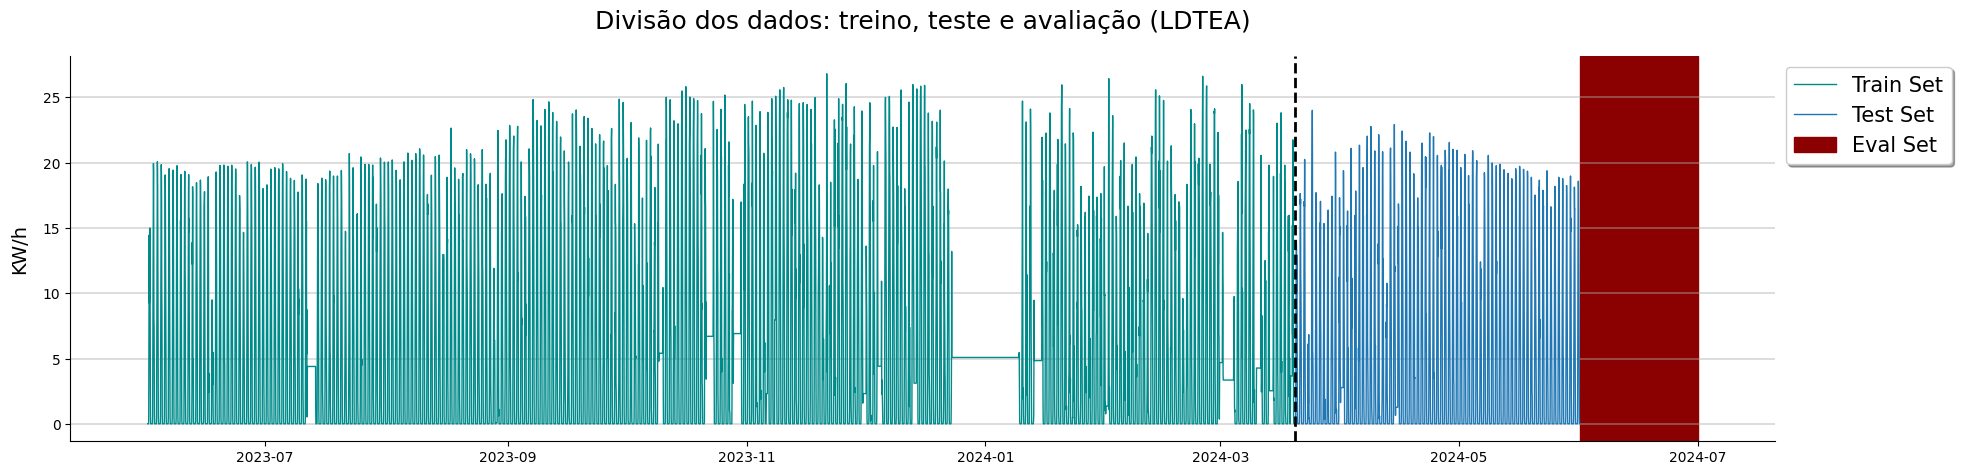

In [7]:
plt.figure(figsize=(22, 5))
plt.plot(df_train.index, df_train[TARGET], lw=1, color=color_train, label="Train Set")
plt.plot(df_test.index, df_test[TARGET], lw=1, color=color_test, label="Test Set")
plt.plot(df_eval.index, df_eval[TARGET], lw=0)

plt.xlabel("")
plt.ylabel("KW/h", fontsize=14, labelpad=10)
plt.title("Divisão dos dados: treino, teste e avaliação (LDTEA)", fontsize=18, pad=20)

plt.axvline(df_train.index.max(), color="black", lw=2, linestyle="--")
plt.axvspan(SPLIT_DATE_EVAL, df_raw.index.max(), alpha=1, color=dark_red, label="Eval Set")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.show()


In [8]:
# Rodar somente um vez para encontrar os melhores parâmetros, muito demorado (pode demorar horas dependendo do dataset e parâmetros)

# import itertools

# p = d = q = range(0, 3)
# pdq_combinations = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
# best_order, best_seasonal_order = sarima_optimizer_aic(df_train[TARGET], pdq_combinations, seasonal_pdq)
# best_order, best_seasonal_order = sarima_optimizer_mae(df_train[TARGET], pdq_combinations, seasonal_pdq)


In [9]:
# Modelo SARIMAX treinado com dados de treino

best_order = (1, 1, 1)
best_seasonal_order = (0, 1, 1, 24)

start_time_model = time.time()

test_model = SARIMAX(
    df_train[TARGET],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
test_model_fit = test_model.fit(disp=False)

elapsed_time_train_set = time.time() - start_time_model
print(f"Tempo de treinamento: {elapsed_time_train_set:.2f} segundos")

Tempo de treinamento: 92.71 segundos


In [10]:
# Fazer previsões com o modelo ARIMA treinado (steps = tamanho do conjunto de teste)

forecast = test_model_fit.get_forecast(steps=len(df_test))
y_pred = forecast.predicted_mean.rename("y_pred")

# Intervalo de confiança 90%
conf_int = forecast.conf_int(alpha=0.1)
conf_int.rename(columns={"lower ldtea": "y_lower", "upper ldtea": "y_upper"}, inplace=True)

# Criar dataframe com os valores reais, previsões e intervalo de confiança
df_pred = pd.concat([df_test, y_pred, conf_int], axis=1)
df_pred.rename(columns={TARGET: "y_true"}, inplace=True)

display(df_pred.head(3))
print_forecast_accuracy(df_pred["y_true"], df_pred["y_pred"], df_train[TARGET], "SARIMA - Test Set")

y_true    y_pred  lower ldtea_avg  upper ldtea_avg
2024-03-20 00:00:00-03:00     0.0  0.235735        -3.198733         3.670202
2024-03-20 01:00:00-03:00     0.0  0.413575        -3.888932         4.716083
2024-03-20 02:00:00-03:00     0.0  0.547740        -4.178352         5.273832

                        Resumo das métricas de precisão (forecast accuracy - SARIMA - Test Set)                         
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.78 -  2.56) | As previsões, em média, estão (1.78 - 2.56) unidades distantes dos valores reais.
RMSE    | ( 2.55 -  3.37) | O erro médio do seu modelo é de (2.55 - 3.37) unidades em relação aos valores observados.
R²      | ( 0.86 -  0.77) | O coeficiente de determinação R² é (86.04% - 86.04%).
MSE     | ( 6.50 - 11.33) | A média dos quadrados das diferenças entre os valores previstos e reais é (6.50 - 6.50)
MAPE    | ( 1.67 -  1.70) | As previsões, em média, estão desviando em (166.92% - 166.92%) dos valores reais.
MASE    | ( 1.64 -  1.

In [11]:
# Salvar métricas em arquivo .csv

metrics = calculate_forecast_accuracy(df_pred["y_true"], df_pred["y_pred"], df_train[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_train_set, 4), 
    "dataset": "test", 
    "features" : str(best_order),
    "date_exp": now
}
save_score_metrics(metrics, "sarima", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/sarima.csv


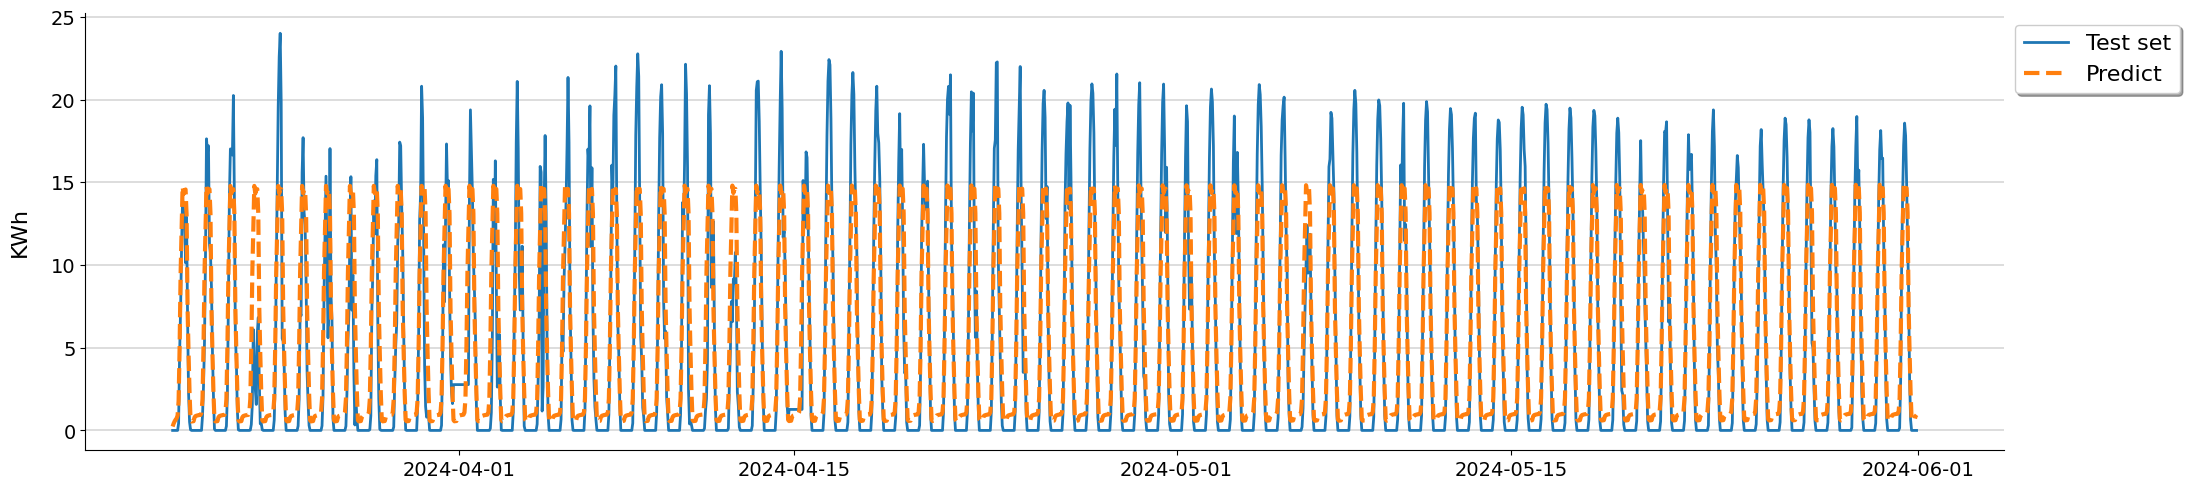

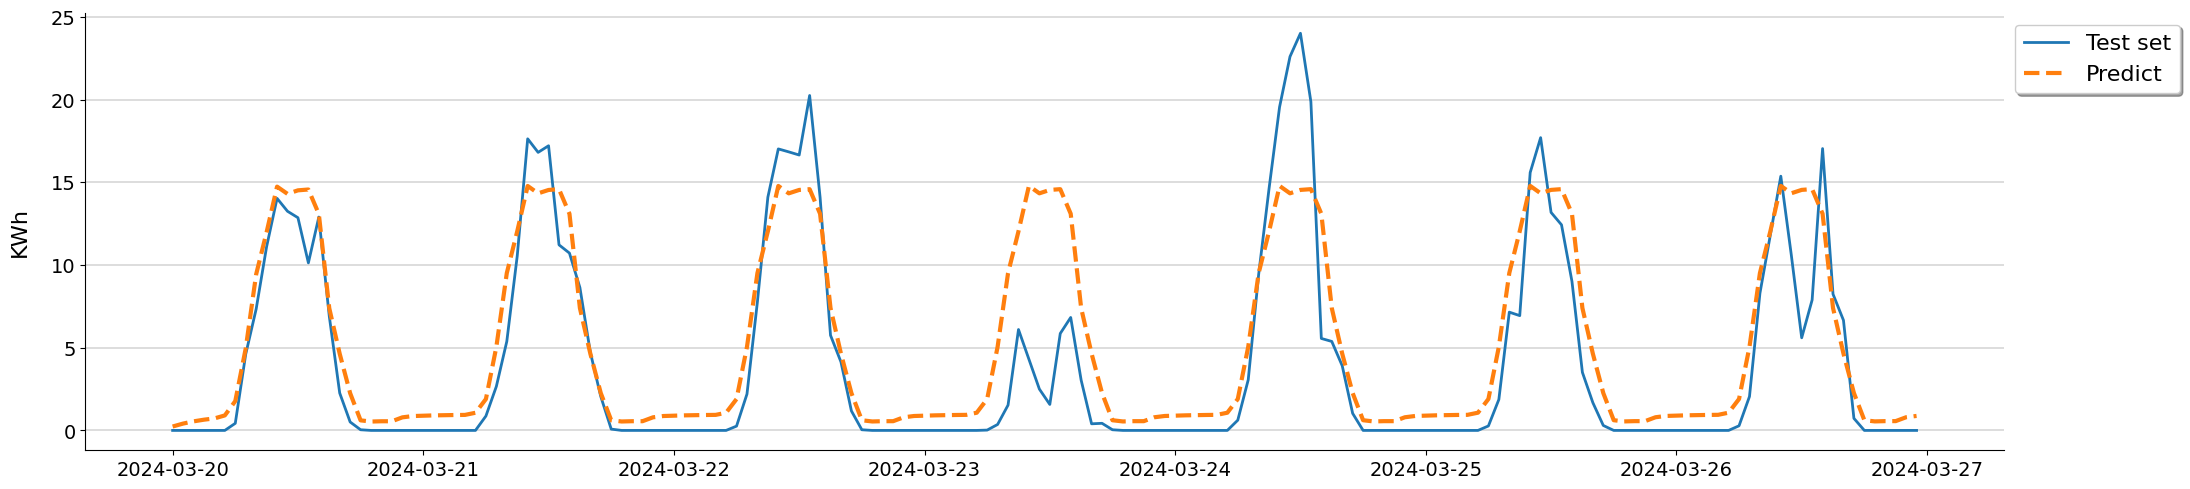

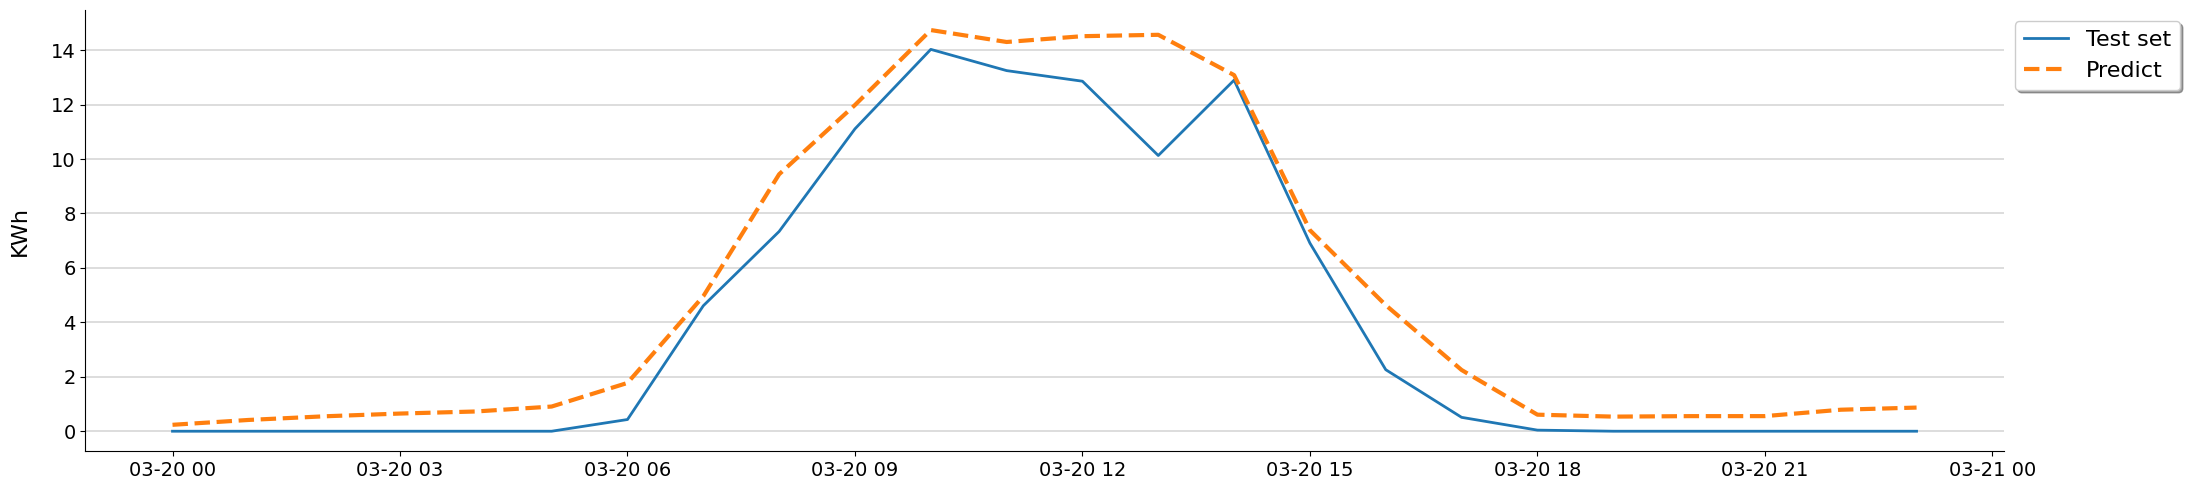

In [12]:
# Plotar previsão de energia (LDTEA) no conjunto de teste

df_plot = pd.concat([df_train[TARGET], df_test[TARGET]], axis=1)
df_plot.columns = ["train", "test"]
df_plot = df_plot.join(df_pred, how="left")
df_plot.drop(columns=["y_true"], inplace=True)

plot_forecast(df_plot[["train", "test", "y_pred"]], "predict_full", span=True)
plot_forecast(df_plot[["test", "y_pred"]], "predict_test", span=True)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=7)
plot_forecast(df_plot[["test", "y_pred"]], "predict_seven", start, end, span=True)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=1)
plot_forecast(df_plot[["test", "y_pred"]], "predict_one", start, end, span=True)


---
##### Forecast SARIMAX
----

In [13]:
# Treinar o modelo SARIMAX com conjunto completo (treino + teste)
start_time_model = time.time()

best_order = (0, 1, 1)
best_seasonal_order = (0, 1, 1, 24)

fc_model = SARIMAX(
    df_base,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
fc_fit = fc_model.fit(disp=False)

elapsed_time_full_set = time.time() - start_time_model
print(f"Tempo de treinamento: {elapsed_time_full_set:.2f} segundos")


Tempo de treinamento: 28.90 segundos


In [14]:
# Prevendo 24 passos à frente (1 dia) do último registro do conjunto de dados

start_time_model = time.time()

forecast = fc_fit.get_forecast(steps=24)
fc_pred = pd.Series(forecast.predicted_mean)

# Obter o intervalo de confiança de 90% para as previsões
fc_conf_int = forecast.conf_int(0.1)

y_eval = df_eval.loc[fc_pred.index]
print_forecast_accuracy(y_eval, fc_pred, df_base[TARGET], "SARIMA - Eval Set (24h)")

                     Resumo das métricas de precisão (forecast accuracy - SARIMA - Eval Set (24h))                      
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 0.84 -  1.56) | As previsões, em média, estão (0.84 - 1.56) unidades distantes dos valores reais.
RMSE    | ( 1.71 -  2.32) | O erro médio do seu modelo é de (1.71 - 2.32) unidades em relação aos valores observados.
R²      | ( 0.92 -  0.85) | O coeficiente de determinação R² é (91.91% - 91.91%).
MSE     | ( 2.92 -  5.39) | A média dos quadrados das diferenças entre os valores previstos e reais é (2.92 - 2.92)
MAPE    | ( 0.22 -  0.22) | As previsões, em média, estão desviando em (21.92% - 21.92%) dos valores reais.
MASE    | ( 0.83 -  0.83

In [15]:
# Salvar métricas em arquivo .csv
metrics = calculate_forecast_accuracy(y_eval, fc_pred, df_base[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_full_set, 4), 
    "dataset": "eval24", 
    "features" : str(best_order),
    "date_exp": now
}
save_score_metrics(metrics, "sarima", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/sarima.csv


In [16]:
plt.figure(figsize=(22, 6))

plt.plot(df_base.index, df_base, label="Train set", color=color_train, lw=2)
plt.plot(fc_pred.index, fc_pred, label="Forecast", color=color_future, lw=2)

# plt.title(
#     "LDTEA - SARIMAX Forecast 24 steps", fontsize=20, fontweight="bold", pad=20
# )
plt.ylabel("KWh", fontsize=16, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig("../figures/sarima/forecast_full_24h.pdf", dpi=300)
    plt.savefig("../figures/sarima/forecast_full_24h.svg", dpi=300)
plt.show()


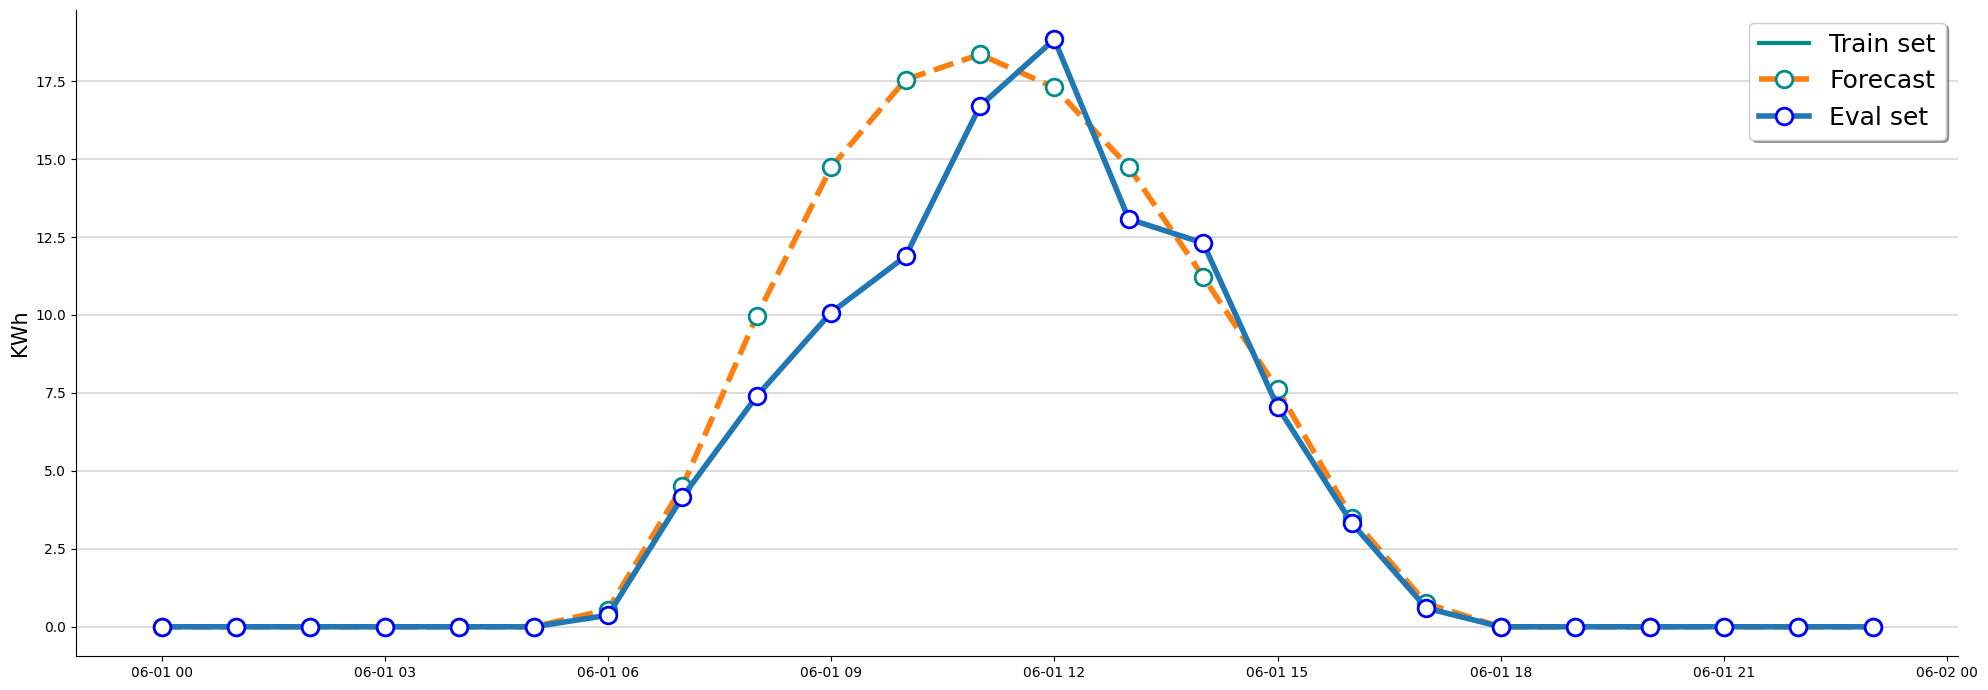

In [17]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]
fc_conf_int_lm = fc_conf_int[fc_conf_int.index > index_min]

plt.figure(figsize=(20, 7))

# plt.fill_between(
#     fc_conf_int_lm.index,
#     fc_conf_int_lm.iloc[:, 0],
#     fc_conf_int_lm.iloc[:, 1],
#     color=color_future,
#     alpha=0.1,
#     label="90% conf int",
# )

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=3,
)

plt.plot(
    fc_pred.index,
    fc_pred,
    label="Forecast",
    color=color_future,
    marker="o",
    ls="--",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgewidth=2,
    markeredgecolor=dark_cyan,
)

plt.plot(
    y_eval.index,
    y_eval,
    label="Eval set",
    color=color_test,
    marker="o",
    lw=4,
    markersize=12,
    markerfacecolor="white",
    markeredgecolor="blue",
    markeredgewidth=2,
)

# plt.title("LDTEA - ARIMA Forecast 24 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=18,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/sarima/forecast_od.pdf", dpi=300)
    plt.savefig("../figures/sarima/forecast_od.svg", dpi=300)
plt.tight_layout()
plt.show()

In [18]:
# Prevendo 144 passos à frente (6 dias) do último registro do conjunto de dados

forecast = fc_fit.get_forecast(steps=len(df_eval))
fc_pred = pd.Series(forecast.predicted_mean)

# Obter o intervalo de confiança de 90% para as previsões
fc_conf_int = forecast.conf_int(0.1)

y_eval = df_eval.loc[fc_pred.index]
print_forecast_accuracy(y_eval, fc_pred, df_base[TARGET], f"ARIMA - Eval Set ({len(df_eval)})")

                      Resumo das métricas de precisão (forecast accuracy - ARIMA - Eval Set (720))                      
------------------------------------------------------------------------------------------------------------------------
Métrica |  24h   | (dia)  | Descrição                                         
------------------------------------------------------------------------------------------------------------------------
MAE     | ( 1.07 -  1.58) | As previsões, em média, estão (1.07 - 1.58) unidades distantes dos valores reais.
RMSE    | ( 2.38 -  3.00) | O erro médio do seu modelo é de (2.38 - 3.00) unidades em relação aos valores observados.
R²      | ( 0.84 -  0.76) | O coeficiente de determinação R² é (84.27% - 84.27%).
MSE     | ( 5.69 -  9.02) | A média dos quadrados das diferenças entre os valores previstos e reais é (5.69 - 5.69)
MAPE    | ( 0.47 -  0.42) | As previsões, em média, estão desviando em (47.19% - 47.19%) dos valores reais.
MASE    | ( 0.85 -  0.81

In [19]:
metrics = calculate_forecast_accuracy(y_eval, fc_pred, df_base[TARGET])
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
metrics = {k: round(v, 3) for k, v in metrics.items()}

metadata={
    "time": round(elapsed_time_full_set, 4), 
    "dataset": "eval168", 
    "features" : str(best_order),
    "date_exp": now
}
save_score_metrics(metrics, "sarima", metadata=metadata)

Métricas salvas com sucesso em: /home/vieira/unb/tcc/repos/sige-ai/data/results/estatical_models/sarima.csv


In [20]:
index_min = df_base.index.max()
df_lm = df_base[df_base.index > index_min]
fc_conf_int_lm = fc_conf_int[fc_conf_int.index > index_min]

plt.figure(figsize=(20, 6))

# plt.fill_between(
#     fc_conf_int_lm.index,
#     fc_conf_int_lm.iloc[:, 0],
#     fc_conf_int_lm.iloc[:, 1],
#     color=color_future,
#     alpha=0.1,
#     label="90% ci",
# )

plt.plot(
    df_lm.index,
    df_lm,
    label="Train set",
    color=color_train,
    lw=2.5,
)

plt.plot(
    y_eval.index,
    y_eval,
    label="Eval set",
    color=color_test,
    lw=2.5,
)

plt.plot(
    fc_pred.index,
    fc_pred,
    label="Forecast",
    color=color_future,
    lw=2,
    alpha=0.7,
    linestyle="--",
)


# plt.title("LDTEA - ARIMA Forecast 24 steps", fontsize=18)
plt.ylabel("KWh", fontsize=15)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
if SAVE_PLOT:
    plt.savefig("../figures/sarima/forecast_sd.pdf", dpi=300)
    plt.savefig("../figures/sarima/forecast_sd.svg", dpi=300)
plt.tight_layout()
plt.show()

In [21]:
# salvar modelo treinado com conjunto completo de dados

save_model(fc_fit, "sarimax")


Modelo sarimax salvo em /home/vieira/unb/tcc/repos/sige-ai/models
